In [3]:
import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# Données
## Données de consommation

In [4]:
data = pd.read_csv("data/data.csv", sep=';')

data.head()

,Date,Consommation (MW),Thermique (MW),Bagasse/charbon (MW),Hydraulique (MW),Photovoltaïque (MW),Eolien (MW),Bioénergies (MW)
0,01/01/2017 04:00,258.452,29.471,198.937,29.183,-0.434,-0.059,1.353
1,01/01/2017 05:00,251.673,30.472,194.092,26.283,-0.427,-0.060,1.313
2,01/01/2017 06:00,242.021,30.010,181.286,29.805,-0.359,-0.062,1.341
3,01/01/2017 07:00,233.028,24.341,173.220,22.226,11.997,-0.042,1.285
4,01/01/2017 08:00,245.900,14.836,163.957,19.252,46.460,0.030,1.365


In [5]:
data["Consommation renouvelable (MW)"] = data.loc[:,"Hydraulique (MW)":"Bioénergies (MW)"].sum(axis=1)

data = data.drop(['Hydraulique (MW)', 'Photovoltaïque (MW)', 'Eolien (MW)',
                 'Bioénergies (MW)'], axis=1)

data.head()

,Date,Consommation (MW),Thermique (MW),Bagasse/charbon (MW),Consommation renouvelable (MW)
0,01/01/2017 04:00,258.452,29.471,198.937,30.043
1,01/01/2017 05:00,251.673,30.472,194.092,27.109
2,01/01/2017 06:00,242.021,30.010,181.286,30.725
3,01/01/2017 07:00,233.028,24.341,173.220,35.466
4,01/01/2017 08:00,245.900,14.836,163.957,67.107


## Données des centrales

In [6]:
data_centrales = pd.read_csv("data/maintenance.csv", sep=';')

data_centrales.head()

,centrale,type,Pmax (MW),nb unités,capacité totale (MW),Pmin (MW),durée minimum marche et arrêt (h),taux annuel arrêt fortuit (%),durée arrêt fortuit (j),nombre maintenances par an par unité,durée maintenance (j),coût marginal (€/MWh),coût de démarrage (€)
0,Bois Rouge,bagasse/charbon,33,3,100,10,6,"0,05",7,1,21,40,50000
1,Le Gol,bagasse/charbon,37,3,111,10,6,"0,05",7,1,21,40,50000
2,La Baie,TAC,40,2,80,15,1,"0,05",7,1,21,150,2000
3,Le Port Est,diesel,18,12,216,0,1,"0,05",7,1,21,80,1000


# Optimisation
## Données

In [7]:
prod_renew = data["Consommation renouvelable (MW)"]

pmin = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        pmin.append(data_centrales['Pmin (MW)'][i])

pmax = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        pmax.append(data_centrales['Pmax (MW)'][i])

n = 24 #durée d'étude (en heures)

demande = data['Consommation (MW)'][:n]

duree_fonc = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        duree_fonc.append(data_centrales['durée minimum marche et arrêt (h)'][i])
        
duree_maint = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        duree_maint.append(data_centrales['durée maintenance (j)'][i])
        
cout_var = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        cout_var.append(data_centrales['coût marginal (€/MWh)'][i])
        
cout_fixe = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        cout_fixe.append(data_centrales['coût de démarrage (€)'][i])

print(pmin)
print(pmax)
print(duree_fonc)
print(duree_maint)
print(cout_var)
print(cout_fixe)

[10, 10, 10, 10, 10, 10, 15, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[33, 33, 33, 37, 37, 37, 40, 40, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
[6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
[40, 40, 40, 40, 40, 40, 150, 150, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
[50000, 50000, 50000, 50000, 50000, 50000, 2000, 2000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


## Variables

In [17]:
model = gp.Model('Maintenance')

## production
var_prod = []
for i in range(len(pmin)):
  prod = []
  for t in range(n):
    prod.append(model.addVar(lb=pmin[i],ub=pmax[i],vtype=GRB.INTEGER))
  var_prod.append(prod)

## on/off
var_on = []
for i in range(len(pmin)):
  on = []
  for t in range(n):
    on.append(model.addVar(vtype=GRB.BINARY))
  var_on.append(on)

## démarrage
var_demarrage = []
for i in range(len(pmin)):
  demarrage = []
  for t in range(n):
    demarrage.append(model.addVar(vtype=GRB.BINARY))
  var_demarrage.append(demarrage)
    
## maintenance
var_maint = []
for i in range(len(pmin)):
  maint = []
  for t in range(n):
    maint.append(model.addVar(vtype=GRB.BINARY))
  var_maint.append(maint)
    
## batterie
# capamax = 25
# stock_batterie = [pulp.LpVariable(f"p1load_{t}",0,capamax) for t in range(0,n)]
# cout_batterie = 50
# prod_batterie = [pulp.LpVariable(f"p1load_{t}",0,capamax) for t in range(0,n)]

## Contraintes

In [18]:
for t in range(n):

    for i in range(len(var_prod)):
        # Toutes les unités produisent entre pmin et pmax (et 0 si elles sont à l'arrêt)
        model.addConstr(var_prod[i][t] >= pmin[i]*var_on[i][t])
        model.addConstr(var_prod[i][t] <= pmax[i]*var_on[i][t])
    
    # La production totale doit subvenir à la demande
    prod_t = gp.quicksum(var_prod[i][t] for i in range(len(var_prod)))
    model.addConstr(prod_t + prod_renew[t] >= demande[t])

## Objectif

In [19]:
somme = 0
for t in range (n):
    for i in range(len(var_prod)):
        somme += var_prod[i][t]*cout_var[i]
        somme += demarrage[i]*cout_fixe[i]

model.setObjective(somme, GRB.MINIMIZE)

## Run

In [20]:
# Verify model formulation
model.write('maintenance.lp')

# Run optimization engine
start = time.time()
model.optimize()
end = time.time()

print(end-start)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 984 rows, 1920 columns and 2112 nonzeros
Model fingerprint: 0x0fc82bce
Variable types: 0 continuous, 1920 integer (1440 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [4e+01, 1e+06]
  Bounds range     [1e+00, 4e+01]
  RHS range        [2e+02, 3e+02]
Found heuristic solution: objective 408640.00000
Found heuristic solution: objective 381790.00000
Presolve removed 984 rows and 1920 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 1 (of 4 available processors)

Solution count 3: 293520 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.935200000000e+05, best bound 2.935200000000e+05, gap 0.0000%
0.03913164138793945


# Résultats

In [23]:
def display_results(verbose=False):

    fig = plt.figure(figsize=(10,10))
    plt.plot(demande,'b', label='Demande')

    current_site = 0
    prod = []
    #Pour chaque usine
    for j in range (data_centrales.shape[0]):
        plant_j = []

        #Pour chaque jour
        for t in range(n):
            prod_t = 0

            #Pour chaque unité de production
            for i in range(current_site, current_site + data_centrales['nb unités'][j]):
                prod_t += var_prod[i][t].x
            plant_j.append(prod_t)

        current_site += data_centrales['nb unités'][j]
        prod.append(plant_j)
        
        if verbose:
            plt.plot(plant_j,label=data_centrales['centrale'][j])
            
    prod_totale = [sum([prod[i][t] for i in range(len(prod))]) + prod_renew[t] for t in range(n)]


    plt.plot(prod_totale, label='Prod totale')

    plt.legend(loc='upper right')
    plt.xlim(0,24)
    plt.show()

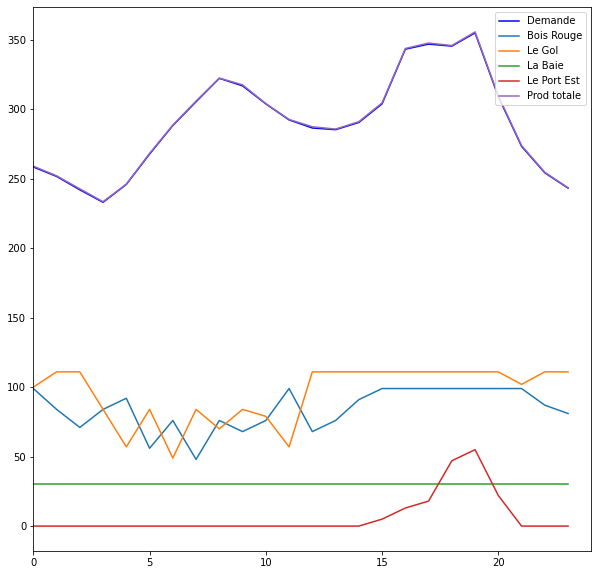

In [24]:
display_results(True)